In [1]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

In [2]:
df = pd.read_csv('../modelDatasets/CIMdataset.csv')

In [4]:
df.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'sYear', u'IntID', u'Rutting', u'IRI',
       u'PSC', u'PPC', u'PRC', u'Alli', u'Long', u'SR', u'Begin ARM',
       u'End ARM', u'UID', u'Is Bridge', u'Lane Surface Type', u'Lane Miles',
       u'Region_x', u'Federal Functional Class', u'Construction End Date',
       u'Substantial Completion Date', u'Contract Type Description',
       u'Surface Type Code', u'Surface Type Description', u'Surface Thickness',
       u'Treat Base Type Code', u'Treat Base Type Description',
       u'Treat Base Thickness', u'UTreat Base Thickness', u'cYear',
       u'Traffic Year', u'ESALs', u'Construction Year', u'Major Rehab Year',
       u'Segment Lane Miles', u'ESALs Since Major Rehab', u'Total Thickness',
       u'Total Surface Thickness', u'Listed Surface Type', u'Pavement Type',
       u'Construction Pavement Type', u'Major Rehab Type',
       u'Prior Major Rehab Year', u'Prior Major Rehab Type', u'sfThick',
       u'Tthick', u'TSfThick', u'STcode', u'cumPPT', 

In [14]:
df['Surface Type Code'].value_counts().head(3)

BA    189
Z2     49
AA     46
dtype: int64

In [15]:
def getCode(row):
    code = row['Surface Type Code']
    if code in ['BA', 'Z2', 'AA']:
        return code
    return 'Other'

In [16]:
df['stCode'] = df.apply(getCode, axis = 1)

In [19]:
#Chose to leave out the effect of the base thicknesses due to insufficient dataset
print len(df[df['Treat Base Thickness'] > 0])*100.0/len(df)
print len(df[df['UTreat Base Thickness'] > 0])*100.0/len(df)

2.65151515152
12.5


In [20]:
df['cumFTPrep'] = df['ciCumPPT'].mul(df['ciCumFTC'])

In [24]:
df['LcumFTPrep'] = np.log(df['cumFTPrep'].add(1))

In [25]:
df['LcumFTPrep'].describe()

count    528.000000
mean      10.641068
std        4.315993
min        0.000000
25%       10.923617
50%       12.119837
75%       12.989179
max       16.753121
Name: LcumFTPrep, dtype: float64

In [26]:
df['LcumESALs'] = np.log(df['ciCumESALs'].add(1))

In [27]:
df['LcumESALs'].describe()

count    528.000000
mean      12.750448
std        1.344799
min        8.263571
25%       11.966271
50%       12.809657
75%       13.600466
max       16.318268
Name: LcumESALs, dtype: float64

In [28]:
df['L_ESALs'] = np.log(df['ESALs'].add(1))
df['L_ESALs'].describe()

count    528.000000
mean      11.340312
std        1.198568
min        7.469084
25%       10.705679
50%       11.435963
75%       12.052210
max       14.604483
Name: L_ESALs, dtype: float64

In [29]:
df['ciCumPPT'].describe()

count      528.000000
mean      4677.499255
std       3847.977620
min        315.529999
25%       1761.647495
50%       3320.970062
75%       6925.090027
max      21811.219971
Name: ciCumPPT, dtype: float64

In [30]:
df['ciCumPPTX1000'] = df['ciCumPPT'].div(1000)

In [32]:
ds = df[[u'prevAlli', u'prevLong', u'ciAlli', u'ciLong', 'L_ESALs', 'LcumESALs', u'Is Bridge', u'sfThick',u'TSfThick',
         u'Tthick', u'stCode', u'ciMMinT', u'ciMMaxT', 'ciCumPPTX1000', 'LcumFTPrep', u'cumESALs', u'cumFTC', 
         u'IRIsi', u'pAlli', u'pLong',  u'ciCumESALs', u'meanMinTemp', u'meanMaxTemp',
       u'ciCumPPT', u'ciCumFTC',  'cumFTPrep',  u'ESALs', u'cumPPT']]

In [33]:
ds.columns = [u'prevAlli', u'prevLong', u'ciAlli', u'ciLong', 'L_ESALs', 'LcumESALs', u'IsBridge', u'sfThick',u'TSfThick',
         u'Tthick', u'stCode', u'ciMMinT', u'ciMMaxT', 'ciCumPPTX1000', 'LcumFTPrep', u'cumESALs', u'cumFTC', 
         u'IRIsi', u'pAlli', u'pLong',  u'ciCumESALs', u'meanMinTemp', u'meanMaxTemp',
       u'ciCumPPT', u'ciCumFTC',  'cumFTPrep',  u'ESALs', u'cumPPT']

In [65]:
data = ds[[u'prevAlli', u'prevLong', u'ciAlli', u'ciLong', 'L_ESALs', 'LcumESALs', u'IsBridge', u'sfThick',u'TSfThick',
         u'Tthick', u'stCode', u'ciMMinT', u'ciMMaxT', 'ciCumPPTX1000', 'LcumFTPrep', u'ciCumPPT']]

In [35]:
data.IsBridge.value_counts()

0    510
1     18
dtype: int64

# Endogeneity Bias Correction for Surface Thickness variable

In [38]:
def runOLS(y, parameters):
    X = data[parameters]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    result = model.fit()
    return result.summary()

In [40]:
y = data.sfThick
parameters = [u'prevAlli', u'prevLong', 'L_ESALs', u'TSfThick',
             u'Tthick', u'ciMMinT', u'ciMMaxT', 'ciCumPPTX1000', 'LcumFTPrep']
run1 = runOLS(y, parameters)
print run1

                            OLS Regression Results                            
Dep. Variable:                sfThick   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     6.764
Date:                Sat, 24 Oct 2015   Prob (F-statistic):           3.34e-09
Time:                        10:44:36   Log-Likelihood:                 263.10
No. Observations:                 528   AIC:                            -506.2
Df Residuals:                     518   BIC:                            -463.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.2277      0.094      2.420

In [44]:
y = data.sfThick
parameters = [u'prevAlli', u'prevLong', 'L_ESALs',
             u'Tthick', u'ciMMinT', u'ciMMaxT', 'LcumFTPrep']
run2 = runOLS(y, parameters)
print run2

                            OLS Regression Results                            
Dep. Variable:                sfThick   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     7.950
Date:                Sat, 24 Oct 2015   Prob (F-statistic):           3.51e-09
Time:                        10:51:07   Log-Likelihood:                 260.61
No. Observations:                 528   AIC:                            -505.2
Df Residuals:                     520   BIC:                            -471.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1709      0.083      2.055      0.0

In [66]:
data.loc[:,'LprevAlli'] = np.log(data.prevAlli.add(0.1))
data.loc[:,'LprevLong'] = np.log(data.prevLong.add(0.1))
data.loc[:,'L_TSfThick'] = np.log(data.TSfThick.add(0.01))
data.loc[:,'L_Tthick'] = np.log(data.Tthick.add(0.01))
data.loc[:,'L_MMinT'] = np.log(data.ciMMinT.add(0.1))
data.loc[:,'L_MMaxT'] = np.log(data.ciMMaxT.add(0.1))
data.loc[:,'LcumPPT'] = np.log(data.ciCumPPT.add(1))

In [71]:
y = np.log(data.sfThick.add(0.01))
# 'LprevAlli', 'LprevLong', 'L_TSfThick', 'L_Tthick', 'L_MMaxT','L_MMinT', 
parameters = ['LprevAlli', 'LprevLong', 'L_TSfThick', 'L_Tthick', 'L_ESALs' ]
run3 = runOLS(y, parameters)
print run3

                            OLS Regression Results                            
Dep. Variable:                sfThick   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     23.34
Date:                Sat, 24 Oct 2015   Prob (F-statistic):           3.43e-21
Time:                        11:19:05   Log-Likelihood:                -562.00
No. Observations:                 528   AIC:                             1136.
Df Residuals:                     522   BIC:                             1162.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -2.6547      0.328     -8.084      0.0

# Endogeneity Bias Correction for Surface Type

In [76]:
# [[u'prevAlli', u'prevLong', u'ciAlli', u'ciLong', 'L_ESALs', 'LcumESALs', u'IsBridge', u'sfThick',u'TSfThick',
#          u'Tthick', u'stCode', u'ciMMinT', u'ciMMaxT', 'ciCumPPTX1000', 'LcumFTPrep', u'ciCumPPT']]
X = data[[u'sfThick', 'L_ESALs', 'LcumFTPrep']]
y = data['stCode']
X = sm.add_constant(X, prepend = False)
model = sm.MNLogit(y,X)
model_fit = model.fit()
print model_fit.summary()

Optimization terminated successfully.
         Current function value: 1.118871
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                 stCode   No. Observations:                  528
Model:                        MNLogit   Df Residuals:                      516
Method:                           MLE   Df Model:                            9
Date:                Sat, 24 Oct 2015   Pseudo R-squ.:                 0.03354
Time:                        11:36:04   Log-Likelihood:                -590.76
converged:                       True   LL-Null:                       -611.27
                                        LLR p-value:                 4.989e-06
   stCode=BA       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
sfThick          0.4769      1.115      0.428      0.669        -1.708     2.662
L_ESALs         -0.3305

Optimization terminated successfully.
         Current function value: 1.118871
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                 stCode   No. Observations:                  528
Model:                        MNLogit   Df Residuals:                      516
Method:                           MLE   Df Model:                            9
Date:                Sat, 24 Oct 2015   Pseudo R-squ.:                 0.03354
Time:                        11:30:31   Log-Likelihood:                -590.76
converged:                       True   LL-Null:                       -611.27
                                        LLR p-value:                 4.989e-06
   stCode=BA       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
sfThick          0.4769      1.115      0.428      0.669        -1.708     2.662
L_ESALs         -0.3305

In [77]:
X = data[['L_ESALs', 'LcumFTPrep']]
y = data['stCode']
X = sm.add_constant(X, prepend = False)
model = sm.MNLogit(y,X)
model_fit = model.fit()
print model_fit.summary()

Optimization terminated successfully.
         Current function value: 1.129974
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                 stCode   No. Observations:                  528
Model:                        MNLogit   Df Residuals:                      519
Method:                           MLE   Df Model:                            6
Date:                Sat, 24 Oct 2015   Pseudo R-squ.:                 0.02395
Time:                        11:36:21   Log-Likelihood:                -596.63
converged:                       True   LL-Null:                       -611.27
                                        LLR p-value:                 5.381e-05
   stCode=BA       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
L_ESALs         -0.3171      0.143     -2.213      0.027        -0.598    -0.036
LcumFTPrep      -0.1365

# Crack Initiation Model - Cox Model

In [102]:
import statsmodels.formula.api as smf

In [101]:
data.columns

Index([     u'prevAlli',      u'prevLong',        u'ciAlli',        u'ciLong',
             u'L_ESALs',     u'LcumESALs',      u'IsBridge',       u'sfThick',
            u'TSfThick',        u'Tthick',        u'stCode',       u'ciMMinT',
             u'ciMMaxT', u'ciCumPPTX1000',    u'LcumFTPrep',      u'ciCumPPT',
           u'LprevAlli',     u'LprevLong',    u'L_TSfThick',      u'L_Tthick',
             u'L_MMinT',       u'L_MMaxT',       u'LcumPPT',        u'Censor'],
      dtype='object')

In [84]:
ds.loc[:,'Censor'] = data['ciAlli'] > 0.1

In [109]:
mod = smf.phreg("ciCumESALs ~ 0 +prevAlli + prevLong + sfThick +  TSfThick + Tthick + ciMMaxT + ciMMinT + LcumFTPrep",
                ds, status=ds.Censor)

In [110]:
rslt = mod.fit()
print(rslt.summary())

                         Results: PHReg
Model:                     PH Reg          Sample size:      528
Dependent variable:        ciCumESALs      Num. events:      375
Ties:                      Breslow                              
----------------------------------------------------------------
            log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
----------------------------------------------------------------
prevAlli   -0.0073    0.0059 0.9928 -1.2322 0.2179 0.9814 1.0043
prevLong    0.0081    0.0029 1.0081  2.7951 0.0052 1.0024 1.0139
sfThick     0.2847    0.3659 1.3294  0.7782 0.4364 0.6490 2.7232
TSfThick   -0.3784    0.2451 0.6850 -1.5439 0.1226 0.4237 1.1074
Tthick     -0.0945    0.1309 0.9099 -0.7214 0.4706 0.7039 1.1760
ciMMaxT    -0.0957    0.0230 0.9087 -4.1686 0.0000 0.8687 0.9505
ciMMinT    -0.0431    0.0280 0.9578 -1.5374 0.1242 0.9066 1.0119
LcumFTPrep -0.0397    0.0112 0.9610 -3.5421 0.0004 0.9401 0.9824
Confidence intervals are for the hazard ratios


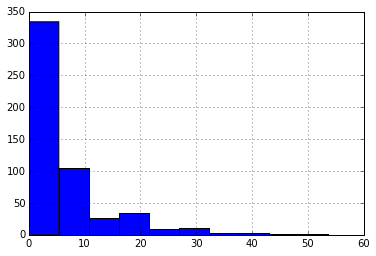

In [3]:
%matplotlib inline
df.pAlli.hist()

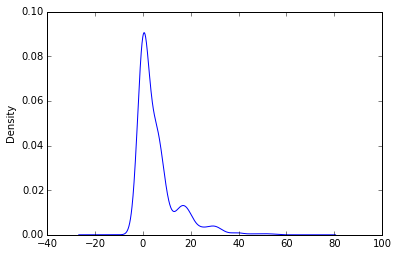

In [5]:
df.pAlli.plot(kind='kde')

In [45]:
df.prevLong.mean()

16.818254503612032

In [51]:
df.prevLong.describe()

count    528.000000
mean      16.818255
std       17.953732
min        0.000000
25%        2.249054
50%       14.962126
75%       28.428039
max      123.428070
Name: prevLong, dtype: float64

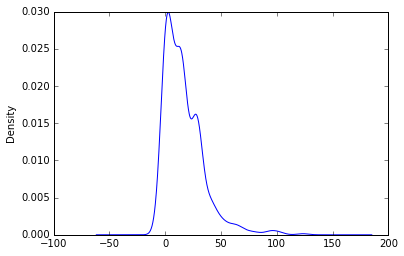

In [44]:
df.prevLong.plot(kind='kde')

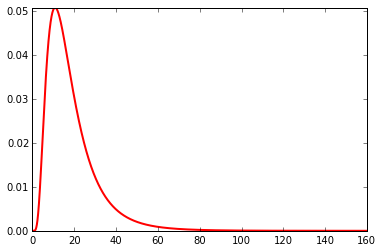

19.0704567723


In [54]:
mu, sigma = 2.75, .6 # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)
x = np.linspace(0, 160, 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
      / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()
print s.mean()

In [36]:
print s.mean()

10.3063911807


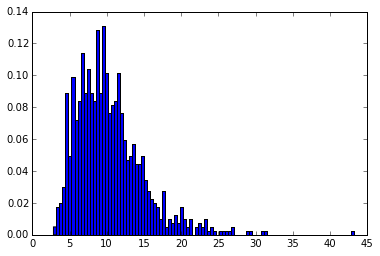

In [37]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')

In [11]:
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
      / (x * sigma * np.sqrt(2 * np.pi)))

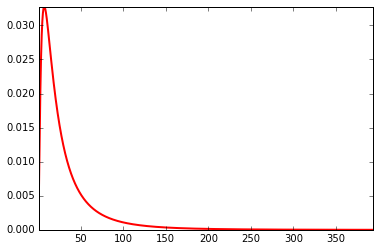

In [12]:
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

In [14]:
print min(bins), max(bins)

0.698721353012 393.811784606


In [55]:
data = pd.read_csv('../modelDatasets/FWD.csv')

In [56]:
data.columns

Index([u'Unnamed: 0', u'sYear', u'IntID', u'Rutting', u'IRI', u'PSC', u'PPC',
       u'PRC', u'Alli', u'Long', u'SR', u'Begin ARM', u'End ARM', u'UID',
       u'Is Bridge', u'Lane Surface Type', u'Lane Miles', u'Region_x',
       u'Federal Functional Class', u'Construction End Date',
       u'Substantial Completion Date', u'Contract Type Description',
       u'Surface Type Code', u'Surface Type Description', u'Surface Thickness',
       u'Treat Base Type Code', u'Treat Base Type Description',
       u'Treat Base Thickness', u'UTreat Base Thickness', u'cYear',
       u'Traffic Year', u'ESALs', u'Construction Year', u'Major Rehab Year',
       u'Segment Lane Miles', u'ESALs Since Major Rehab', u'Total Thickness',
       u'Total Surface Thickness', u'Listed Surface Type', u'Pavement Type',
       u'Construction Pavement Type', u'Major Rehab Type',
       u'Prior Major Rehab Year', u'Prior Major Rehab Type', u'sfThick',
       u'Tthick', u'TSfThick', u'STcode', u'cumPPT', u'meanMinTemp',
 

In [59]:
print len(data[data['Treat Base Thickness'] > 0])*100.0/ len(data)
print len(data[data['UTreat Base Thickness'] > 0])*100.0/ len(data)

22.5814352192
25.7898603968


In [61]:
data['Treat Base Type Description'].value_counts()

Crushed Stone                                                        737
Asphalt Treated Base Or Bituminous Admix                             121
Concrete Treated Base, Unfinished Portland Cement, Or Soil Cement     94
dtype: int64

In [64]:
def getBaseThickness(row, category):
    cat = row['Treat Base Type Description']
    t   = row['Treat Base Thickness']
    if cat == category:
        return t
    else:
        return 0

In [65]:
data['actbthick'] = data.apply(getBaseThickness, axis = 1, args = ('Asphalt Treated Base Or Bituminous Admix',))
data['pctbthick'] = data.apply(getBaseThickness, axis = 1, args = ('Concrete Treated Base, Unfinished Portland Cement, Or Soil Cement',))

In [69]:
data['cumESALs'].corr(data['ESALs Since Major Rehab'])

0.95553405577513684

In [70]:
print len(data[data.STcode == 'AA'])
print len(data[data.STcode == 'BA'])

0
1936


In [87]:
def getSTcode(row, cat):
    val = row['Surface Type Code']
    if val == cat:
        return 1
    return 0

In [91]:
data['BA'] = data.apply(getSTcode, axis = 1, args = ('BA',))
data['AA'] = data.apply(getSTcode, axis = 1, args = ('AA',))
print len(data[data.BA == 1])
print len(data[data.AA == 1])

1936
152


In [92]:
data['ftprep'] = data.PPT.mul(data.FTCycles)

In [93]:
data['E_Alli'] = np.random.lognormal(2.25, 0.4, len(data)) #lognormal distribution with mean 2.25, and stdev 0.4
data['E_Long'] = np.random.lognormal(2.75, 0.6, len(data)) #lognormal distribution with mean 2.75, and stdev 0.6
#-------------------------------------------------------------------------------------------------
# Note that these distributions were estimated using observations from another dataset.
# -------------------------------------------------------------------------------------------

In [106]:
dataset = data[[u'UID', u'Is Bridge', u'Lane Surface Type', u'Lane Miles', u'Region_x',
       u'Federal Functional Class', u'Surface Type Code', u'Surface Type Description',
       u'Treat Base Type Code', u'Treat Base Type Description',
       u'Treat Base Thickness', u'UTreat Base Thickness', u'ESALs', u'Major Rehab Year',
       u'ESALs Since Major Rehab', u'sfThick',
       u'Tthick', u'TSfThick', u'meanMinTemp',
       u'meanMaxTemp', u'cumESALs', u'IRIsi', u'pAlli', u'pLong', 'E_Alli', 'E_Long',
       u'PPT', u'MinT', u'MaxT', u'FTCycles', 'actbthick', 'pctbthick','ftprep', 'BA', 'AA']]

In [107]:
# ESALs Since Major Rehab are the cumulative ESALs, which have a correlation coefficient of 0.955 with imputed data!
dataset.columns = [u'UID', u'IsBridge', u'Lane Surface Type', u'LaneMiles', u'Region_x',
       u'FFClass', u'SurfaceTypeCode', u'STDescription', u'TreatBaseCode', u'TreatBaseDescription',
       u'TBThick', u'untrthick', u'Y_ESAL', u'MajorRehabYear', u'Cum_ESAL', u'SURFTHK',
       u'ULT', u'TSfThick', u'tmin', u'tmax', u'cumESALs', u'IRIsi', u'Alli', u'Long', 'E_Alli', 'E_Long',
       u'prep', u'MinT', u'MaxT', u'FTCycles',  'actbthick', 'pctbthick','ftprep', 'BA', 'AA']

In [110]:
dataset[['SURFTHK', 'ftprep', 'Alli', 'prep']].head()

,SURFTHK,ftprep,Alli,prep
0,0.17,78155.358887,0.568182,2056.719971
1,0.15,28866.599487,3.472223,343.649994
2,0.25,4056.779846,0.852273,193.179993
3,0.25,6786.360077,1.231061,323.160004
4,0.15,4056.779846,5.523992,193.179993


In [111]:
print len(dataset[dataset.ftprep.isnull() == True])

0


In [109]:
dataset.to_csv('../modelDatasets/ndata.csv') #Saving final dataset for running simulation!

In [105]:
dataset.Alli.max()

59.488655399999999

In [ ]:
tdata = pd.read_csv('../modelDatasets/wtraffic.csv')